# Finetuning SmSA
SmSA is a Sentiment Analysis dataset with 3 possible labels: `positive`, `negative`, and `neutral`

In [ ]:
!pip install transformers
!pip install nltk
!pip install utils

In [2]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
df = pd.read_csv('/content/Hasil Preprocessing & Pelabelan Lexicon.csv')
df.head()

,text,label
0,lemot sering tersendat tidak bisa,negative
1,bantu banget transaksi apa terima kasih,positive
2,sangat bagus biaya admin keren,positive
3,bagus bantu terima kasih,positive
4,transaksi jelek sering error,negative


## **Cek Dimensi Data**

In [4]:
df.shape

(5751, 2)

## **Cek Data Kembar**

In [5]:
df_new = df.copy()
df_new['text'] = df_new['text'].drop_duplicates()
df_new = df_new.dropna()
df_new = df_new.reset_index(drop=True)
df_new

,text,label
0,lemot sering tersendat tidak bisa,negative
1,bantu banget transaksi apa terima kasih,positive
2,sangat bagus biaya admin keren,positive
3,bagus bantu terima kasih,positive
4,transaksi jelek sering error,negative
...,...,...
5745,mudah praktis,positive
5746,akun tidak bisa masuk jelek,negative
5747,sering ganggu lemot aaaaa,negative
5748,tidak masuk saldo aneh banget tidak bisa,negative


In [6]:
df_new.shape

(5750, 2)

## **Cek Frekuensi Label**

In [7]:
df_new.label.value_counts()

negative    3045
positive    1645
neutral     1060
Name: label, dtype: int64

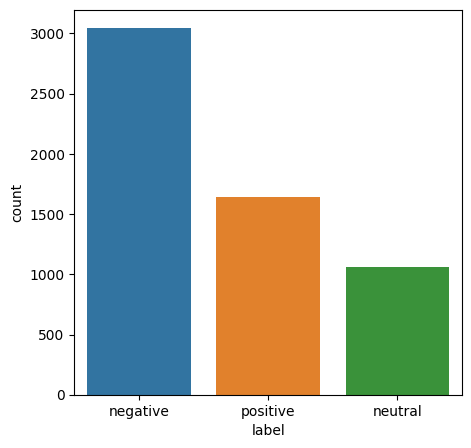

In [8]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_new['label'])
plt.show()

## **Cek NaN**

In [9]:
df_new.loc[pd.isna(df_new["text"]), :].index

Int64Index([], dtype='int64')

#**Train Test Split**

In [10]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df_new,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

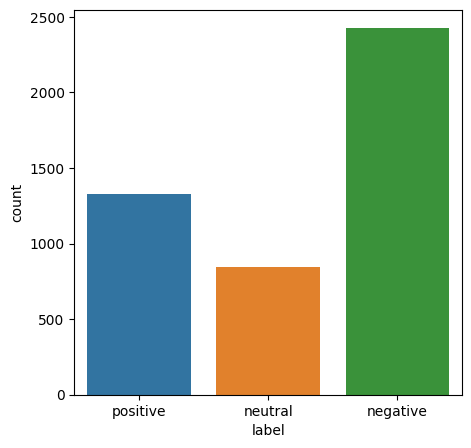

In [11]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_train['label'])
plt.show()

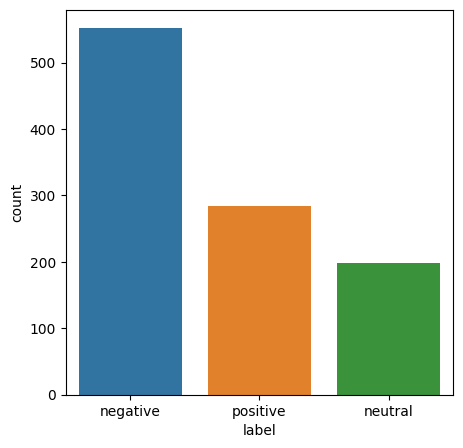

In [12]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_val['label'])
plt.show()

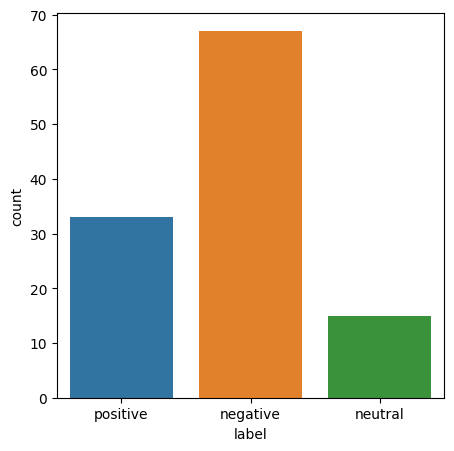

In [13]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_test['label'])
plt.show()

In [14]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 4600
Total Val  : 1035
Total Test : 115


In [15]:
actual_label = df_test['label']

In [16]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

# Import Environment

In [3]:
import torch

###
# Forward Function
###

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

# Forward function for word classification
def forward_word_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 4:
        (subword_batch, mask_batch, subword_to_word_indices_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 5:
        (subword_batch, mask_batch, token_type_batch, subword_to_word_indices_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    subword_to_word_indices_batch = torch.LongTensor(subword_to_word_indices_batch)
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        subword_to_word_indices_batch = subword_to_word_indices_batch.cuda()
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, subword_to_word_indices_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyps = []
    list_labels = []
    hyps_list = torch.topk(logits, k=1, dim=-1)[1].squeeze(dim=-1)
    for i in range(len(hyps_list)):
        hyps, labels = hyps_list[i].tolist(), label_batch[i].tolist()        
        list_hyp, list_label = [], []
        for j in range(len(hyps)):
            if labels[j] == -100:
                break
            else:
                list_hyp.append(i2w[hyps[j]])
                list_label.append(i2w[labels[j]])
        list_hyps.append(list_hyp)
        list_labels.append(list_label)
        
    return loss, list_hyps, list_labels

# Forward function for sequence multilabel classification
def forward_sequence_multi_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2] # logits list<tensor(bs, num_label)> ~ list of batch prediction per class 
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = [torch.topk(logit, 1)[1] for logit in logits] # list<tensor(bs)>
    batch_size = label_batch.shape[0]
    num_label = len(hyp)
    for i in range(batch_size):
        hyps = []
        labels = label_batch[i,:].cpu().numpy().tolist()
        for j in range(num_label):
            hyps.append(hyp[j][i].item())
        list_hyp.append([i2w[hyp] for hyp in hyps])
        list_label.append([i2w[label] for label in labels])
        
    return loss, list_hyp, list_label

In [4]:
import utils

In [5]:
!git clone https://github.com/indobenchmark/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 500 (delta 115), reused 142 (delta 111), pack-reused 316
Receiving objects: 100% (500/500), 9.45 MiB | 18.47 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [6]:
import os, sys
sys.path.append('../')
os.chdir('../')

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

In [7]:
###
# common functions
###
def set_seed(seed):   #agar tidak berubah-ubah randomnya, jadi hasilnya akan sama
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):   #untuk menghitung jumlah parameter di indobert
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):   #membantu mendapatkan learning rate
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):   #untuk convert dari metrics evaluasinya kedalam stream
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [8]:
# Set random seed
set_seed(26092020)

# Load Model

In [9]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
#tokenizer
text = "mudah gratis transfer antar bank"

encoding = tokenizer.encode(text)
decoding = tokenizer.decode(encoding)
encoding_input = tokenizer(text)

print(encoding)
print(decoding)
print(encoding_input)

[2, 783, 1243, 4241, 2563, 1117, 3]
[CLS] mudah gratis transfer antar bank [SEP]
{'input_ids': [2, 783, 1243, 4241, 2563, 1117, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [11]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
count_param(model)

124443651

# Prepare Dataset

In [13]:
train_dataset_path = '/content/train2.tsv'
valid_dataset_path = '/content/eval2.tsv'
test_dataset_path = '/content/test2.tsv'

In [14]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_dataset.data.shape, valid_dataset.data.shape, test_dataset.data.shape

((4600, 2), (1035, 2), (115, 2))

In [15]:
#label index
train_dataset.LABEL2INDEX

{'positive': 0, 'neutral': 1, 'negative': 2}

In [16]:
train_dataset.data.sentiment.value_counts()

2    2426
0    1328
1     846
Name: sentiment, dtype: int64

In [17]:
valid_dataset.data.sentiment.value_counts()

2    552
0    284
1    199
Name: sentiment, dtype: int64

In [18]:
test_dataset.data.sentiment.value_counts()

2    67
0    33
1    15
Name: sentiment, dtype: int64

In [19]:
train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


# Test model on sample sentences

In [21]:
text = 'bagus mudah mantap tapi sering error'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bagus mudah mantap tapi sering error | Label : neutral (41.835%)


In [22]:
text = 'aplikasi mudah guna cepat'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: aplikasi mudah guna cepat | Label : neutral (40.006%)


# Fine Tuning & Evaluation

In [23]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score 
from collections import defaultdict

In [25]:
# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []
    
    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:0.7658 LR:0.00000300: 100%|██████████| 144/144 [00:30<00:00,  4.71it/s]


(Epoch 1) TRAIN LOSS:0.7658 ACC:0.67 F1:0.60 REC:0.58 PRE:0.65 LR:0.00000300


  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.6095 ACC:0.76 F1:0.72 REC:0.70 PRE:0.75: 100%|██████████| 33/33 [00:03<00:00, 10.15it/s]


(Epoch 1) VALID LOSS:0.6095 ACC:0.76 F1:0.72 REC:0.70 PRE:0.75


  0%|          | 0/144 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.5267 LR:0.00000300: 100%|██████████| 144/144 [00:31<00:00,  4.54it/s]


(Epoch 2) TRAIN LOSS:0.5267 ACC:0.80 F1:0.77 REC:0.75 PRE:0.79 LR:0.00000300


  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.5411 ACC:0.79 F1:0.75 REC:0.74 PRE:0.78: 100%|██████████| 33/33 [00:03<00:00,  9.28it/s]


(Epoch 2) VALID LOSS:0.5411 ACC:0.79 F1:0.75 REC:0.74 PRE:0.78


  0%|          | 0/144 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.4358 LR:0.00000300: 100%|██████████| 144/144 [00:31<00:00,  4.64it/s]


(Epoch 3) TRAIN LOSS:0.4358 ACC:0.84 F1:0.81 REC:0.80 PRE:0.84 LR:0.00000300


  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.5027 ACC:0.81 F1:0.78 REC:0.77 PRE:0.81: 100%|██████████| 33/33 [00:03<00:00,  9.26it/s]


(Epoch 3) VALID LOSS:0.5027 ACC:0.81 F1:0.78 REC:0.77 PRE:0.81


  0%|          | 0/144 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.3499 LR:0.00000300: 100%|██████████| 144/144 [00:31<00:00,  4.56it/s]


(Epoch 4) TRAIN LOSS:0.3499 ACC:0.88 F1:0.85 REC:0.84 PRE:0.87 LR:0.00000300


  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.4466 ACC:0.84 F1:0.81 REC:0.79 PRE:0.84: 100%|██████████| 33/33 [00:03<00:00, 10.74it/s]


(Epoch 4) VALID LOSS:0.4466 ACC:0.84 F1:0.81 REC:0.79 PRE:0.84


  0%|          | 0/144 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.2855 LR:0.00000300: 100%|██████████| 144/144 [00:30<00:00,  4.70it/s]


(Epoch 5) TRAIN LOSS:0.2855 ACC:0.90 F1:0.88 REC:0.87 PRE:0.90 LR:0.00000300


  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.4360 ACC:0.85 F1:0.82 REC:0.81 PRE:0.84: 100%|██████████| 33/33 [00:03<00:00, 10.63it/s]


(Epoch 5) VALID LOSS:0.4360 ACC:0.85 F1:0.82 REC:0.81 PRE:0.84


# Learning Curve

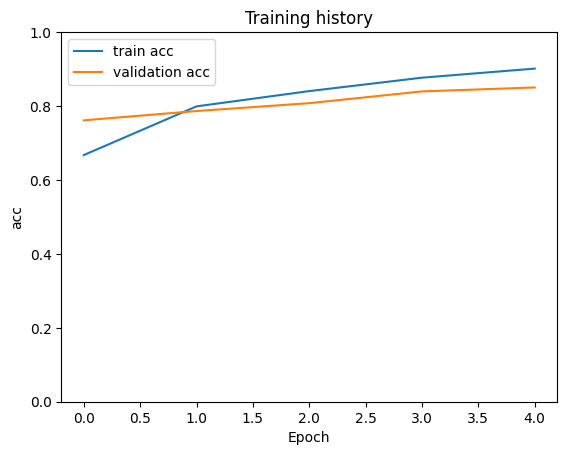

In [28]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [29]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['content', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

# Prediksi Test

In [30]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
#df = pd.DataFrame({'label':list_hyp}).reset_index()
#df.to_csv('pred.txt', index=False)

#print(df)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


In [31]:
test_dataset_path = '/content/test2.tsv'

In [42]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['content', 'category'])
test_df['pred'] = list_hyp
test_df.head()
test_df.to_csv('test result.csv')

# Test fine-tuned model on sample sentences

In [33]:
text = 'bantu banget transaksi apa terima kasih'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bantu banget transaksi apa terima kasih | Label : positive (84.665%)


In [34]:
text = 'lemot sering ngelag ngga bisa'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: lemot sering ngelag ngga bisa | Label : negative (98.969%)


# Evaluasi Model

In [35]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

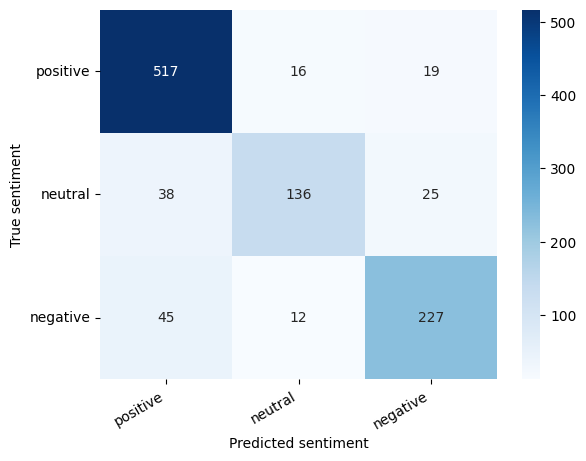

In [36]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [37]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.86      0.94      0.90       552
     neutral       0.83      0.68      0.75       199
    negative       0.84      0.80      0.82       284

    accuracy                           0.85      1035
   macro avg       0.84      0.81      0.82      1035
weighted avg       0.85      0.85      0.85      1035



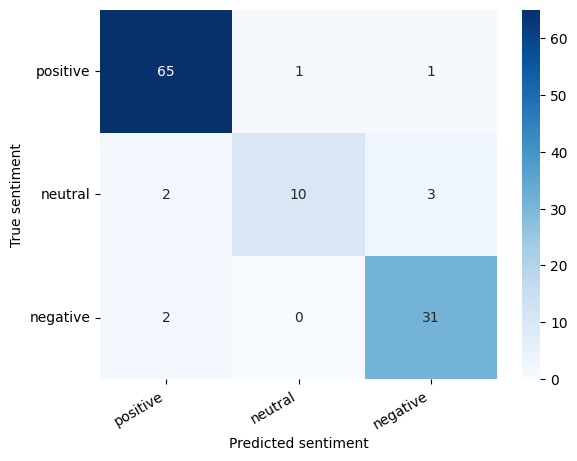

In [38]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [39]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.94      0.97      0.96        67
     neutral       0.91      0.67      0.77        15
    negative       0.89      0.94      0.91        33

    accuracy                           0.92       115
   macro avg       0.91      0.86      0.88       115
weighted avg       0.92      0.92      0.92       115

